<a href="https://colab.research.google.com/github/bcastan24/Data-Science-Projects/blob/main/mvpOrNot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
'''
In this Python Notebook I will use Bayesian Classification to determine if an
MLB player should be considered an MVP canidate or not
My two classes will be MVP candidate and not MVP candidate
My feature will be an arbitrarily calculated value of OPS+WAR+HR
Where I will divide each stat by the MLB average to regularize each term
ex: OPS = .850, WAR = 5.7, HR = 35: (.85/.75) + (5.7/2.0) + (35/15)
The above averages are just arbitrary I will calculate the actual averages in the program

Due to unforseen circumstances of FanGraphs and Baseball Reference blocking pybaseball from web scraping
I have found stats from an outside source and I cleaned it in Excel
I auto split it into train and test data, 2021-2023 is training and 2024 is test data
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

stats_2021_2023 = pd.read_csv('Baseball stats 2021-2023.csv')
stats_2024 = pd.read_csv('Baseball Stats 2024.csv')
stats_2024.head()

#finding the mean each stat in both csv files and then combining them into 1 mean
ops_mean1 = stats_2021_2023['OPS'].mean()
war_mean1 = stats_2021_2023['L-WAR'].mean()
hr_mean1 = stats_2021_2023['HR'].mean()
ops_mean2 = stats_2024['OPS'].mean()
war_mean2 = stats_2024['L-WAR'].mean()
hr_mean2 = stats_2024['HR'].mean()

ops_mean = (ops_mean1 + ops_mean2)/2
war_mean = (war_mean1 + war_mean2)/2
hr_mean = (hr_mean1 + hr_mean2)/2

print(ops_mean)
print(war_mean)
print(hr_mean)


0.7229093490318078
1.685381829815518
14.390266504496902


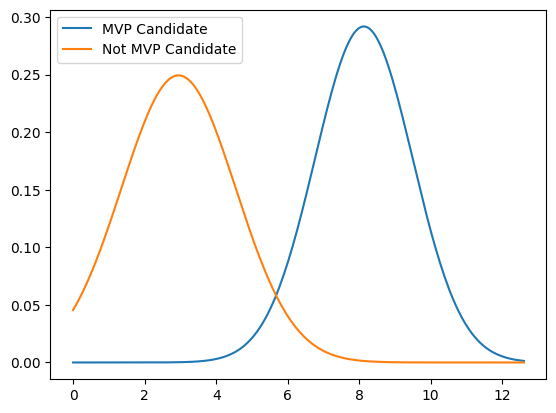

In [3]:
'''
It looks like these averages are a little lower than usual
Usually average OPS is around .750 and replacement level WAR is around 2.0

Now I am going to add the regularized OPS, HR, and WAR together for my feature X
'''
#I will write a function so I don't have to repeat code and I could use it in the future
def calcX(stats, ops_mean, war_mean, hr_mean):
    stats['X'] = (stats['OPS']/ops_mean) + (stats['L-WAR']/war_mean) + (stats['HR']/hr_mean)
    return stats
stat_2021_X = calcX(stats_2021_2023, ops_mean, war_mean, hr_mean)
stat_2024_X = calcX(stats_2024, ops_mean, war_mean, hr_mean)
stat_2021_X.head()

#I will set training and testing data
train_X = stat_2021_X['X']
test_X = stat_2024_X['X']
train_C = stat_2021_X['MVP Candidate']
test_C = stat_2024_X['MVP Candidate']

#split into mvp candidate and non mvp candidates to calculate likelihood of each outcome
X_mvp = train_X[train_C == 1]
X_not_mvp = train_X[train_C == 0]
#calculating mean and std of each set
mvp_mean = X_mvp.mean()
mvp_std = X_mvp.std()
not_mvp_mean = X_not_mvp.mean()
not_mvp_std = X_not_mvp.std()

x_values = np.linspace(train_X.min(), train_X.max(), 200)
#calculating likelihood pdf for each outcome using the formula I was given in my Machine Learning class
likelihood_mvp = 1/(np.sqrt(2*np.pi*mvp_std**2))*np.exp(-(x_values-mvp_mean)**2/(2*mvp_std**2))
likelihood_not_mvp = 1/(np.sqrt(2*np.pi*not_mvp_std**2))*np.exp(-(x_values-not_mvp_mean)**2/(2*not_mvp_std**2))
#showing the likelihoods
plt.plot(x_values, likelihood_mvp, label='MVP Candidate')
plt.plot(x_values, likelihood_not_mvp, label='Not MVP Candidate')
plt.legend()
plt.show()

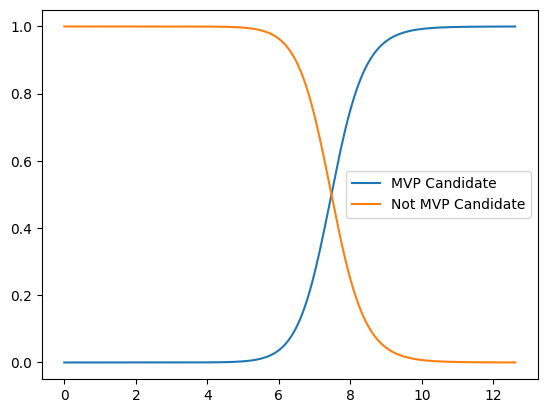

In [4]:
'''
Now that I have calculated the likelihoods I need to calculate the prior and the evidence
'''
prior_mvp = X_mvp.count()/train_X.count()
prior_not_mvp = 1 - prior_mvp
#calculating evidence term
evidence = (prior_mvp*likelihood_mvp) + (prior_not_mvp*likelihood_not_mvp)
#calculating posterior for mvp and non mvp
posterior_mvp = (prior_mvp*likelihood_mvp)/evidence
posterior_not_mvp = (prior_not_mvp*likelihood_not_mvp)/evidence

#plotting the values to visualize
plt.plot(x_values, posterior_mvp, label='MVP Candidate')
plt.plot(x_values, posterior_not_mvp, label='Not MVP Candidate')
plt.legend()
plt.show()




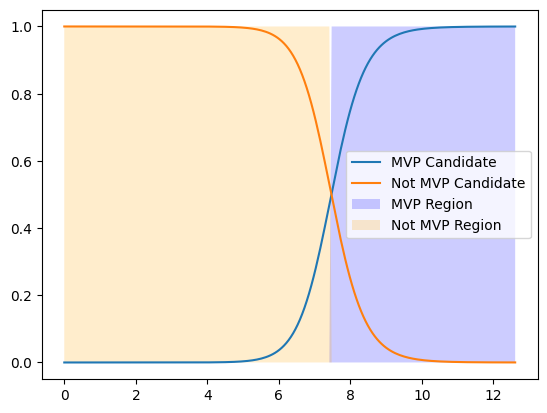

In [5]:
#Now I will make the regions
mvp_region = (posterior_mvp > posterior_not_mvp)
not_mvp_region = (posterior_not_mvp > posterior_mvp)

plt.plot(x_values, posterior_mvp, label='MVP Candidate')
plt.plot(x_values, posterior_not_mvp, label='Not MVP Candidate')
plt.fill_between(x_values, mvp_region, label='MVP Region', facecolor='blue', alpha=0.2)
plt.fill_between(x_values, not_mvp_region, label='Not MVP Region', facecolor='orange', alpha=0.2)
plt.legend()
plt.show()

In [13]:
'''
Time to test the model. I do have to calculate a new likelihood and evidence but
the prior, mean and standard deviation are the same
'''
likelihood_mvp_test = 1/(np.sqrt(2*np.pi*mvp_std**2))*np.exp(-(test_X-mvp_mean)**2/(2*mvp_std**2))
likelihood_not_mvp_test = 1/(np.sqrt(2*np.pi*not_mvp_std**2))*np.exp(-(test_X-not_mvp_mean)**2/(2*not_mvp_std**2))

evidence_test = (prior_mvp*likelihood_mvp_test) + (prior_not_mvp*likelihood_not_mvp_test)

posterior_mvp_test = (prior_mvp*likelihood_mvp_test)/evidence_test

y_pred = (posterior_mvp_test >= 0.85).astype(int)
print(y_pred.head(10))
from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(test_C, y_pred))

0    0
1    0
2    0
3    0
4    0
5    1
6    1
7    1
8    0
9    0
Name: X, dtype: int64
Accuracy:  0.9914529914529915


Overall I am very happy with the results of this. Using such primitive stats and a very basic aprroach I achieved 99.1% accuracy. There was one flaw in my estimation, I did not take into account if the player was in the NL or AL. I looked through the predictions and I saw that Gunnar Henderson was predicted as an MVP Candidate and Francisco Lindor was not. Henderson did have better stats in WAR, OPS, and HRs but he was in the AL where Judge, Soto, and Witt Jr. just had better stats then him and he finished 4th in voting. But Lindor benefitted off less competition in the NL and came runner up in MVP voting. I am proud of how well this works with even such little data. I look forward to my next project.